In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
sns.set_style("whitegrid")

### Simulation

In [3]:
def update(x1, x2, x3, u, f1=0, f2=0, T=1):
    dx1 = -0.2 * x1 - 0.1 * x2 + u + f1 + np.random.normal(scale=0.01)
    dx2 = -0.2 * x2 + 0.1 * x1 - 0.1 * x3 + f2 + np.random.normal(scale=0.01)
    dx3 = -0.2 * x3 + 0.1 * x2 + np.random.normal(scale=0.01)
    x1 = x1 + T * dx1
    x2 = x2 + T * dx2
    x3 = x3 + T * dx3
    return x1, x2, x3

In [4]:
def simulate(x10, x20, x30, u, f1, f2):
    x1, x2, x3 = x10, x20, x30
    rows = []
    for i in range(len(u)):
        rows.append((x1, x2, x3))
        x1, x2, x3 = update(x1, x2, x3, u[i], f1[i], f2[i])
    df = pd.DataFrame(rows, columns=['x1', 'x2', 'x3'])
    return df

In [5]:
def prepare_data(x10, x20, x30, u, f1, f2):
    df = simulate(x10, x20, x30, u, f1, f2)
    df['u'] = u
    df['f1'] = f1
    df['f2'] = f2
    df['x1(k-1)'] = df['x1'].shift(1)
    df['x2(k-1)'] = df['x2'].shift(1)
    df['x3(k-1)'] = df['x3'].shift(1)
    df['dx1'] = df['x1'].diff()
    df.dropna(inplace=True)
    return df

#### No fault

In [6]:
N = 200
t = np.arange(0, N)
u = np.sin(0.1 * t)
f1 = np.zeros(N)
f2 = np.zeros(N)

In [7]:
df_nf = prepare_data(0, 0, 0, u, f1, f2)

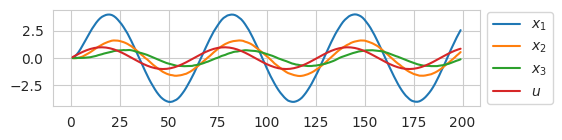

In [8]:
plt.figure(figsize=(5, 1.5))
plt.plot(df_nf[['x1', 'x2', 'x3', 'u']], label=['$x_1$', '$x_2$', '$x_3$', '$u$']);
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('pic/no_fault.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### f1

In [9]:
N = 200
t = np.arange(0, N)
u = np.sin(0.1 * t)
f1 = np.concatenate([np.zeros(N//2), np.ones(N//2)])
f2 = np.zeros(N)

In [10]:
df_f1 = prepare_data(0, 0, 0, u, f1, f2)

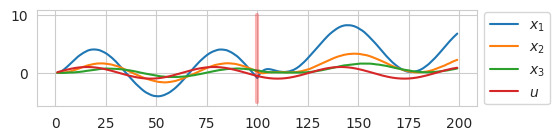

In [11]:
plt.figure(figsize=(5, 1.5))
plt.plot(df_f1[['x1', 'x2', 'x3', 'u']], label=['$x_1$', '$x_2$', '$x_3$', '$u$']);
plt.plot((100, 100), (-5, 10), c='r', alpha=0.3, linewidth=3)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('pic/f1.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### f2

In [12]:
N = 200
t = np.arange(0, N)
u = np.sin(0.1 * t)
f1 = np.zeros(N)
f2 = np.concatenate([np.zeros(N//2), np.ones(N//2)])

In [13]:
df_f2 = prepare_data(0, 0, 0, u, f1, f2)

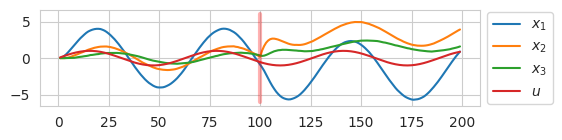

In [14]:
plt.figure(figsize=(5, 1.5))
plt.plot(df_f2[['x1', 'x2', 'x3', 'u']], label=['$x_1$', '$x_2$', '$x_3$', '$u$']);
plt.plot((100, 100), (-6, 6), c='r', alpha=0.3, linewidth=3)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('pic/f2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
df_nf[['x1', 'x2', 'x3', 'u', 'f1', 'f2']].to_csv('data/nf.csv', sep=';')
df_f1[['x1', 'x2', 'x3', 'u', 'f1', 'f2']].to_csv('data/f1.csv', sep=';')
df_f2[['x1', 'x2', 'x3', 'u', 'f1', 'f2']].to_csv('data/f2.csv', sep=';')

### Linear autoregressive models according to Model Structures

#### y1 = f(u)

In [16]:
cols = ['x1(k-1)', 'u']
out = 'x1'
X = df_nf[cols]
y = df_nf[[out]]

In [17]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

In [18]:
reg.score(X, y)

0.9999753001467887

In [19]:
reg.coef_

array([[0.79421545, 0.89893252]])

In [20]:
x1_hat = reg.predict(X)

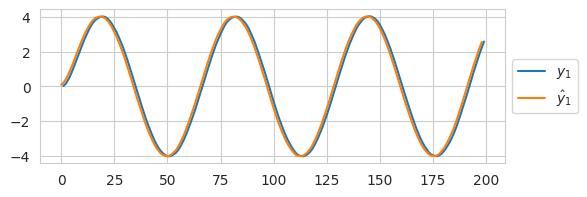

In [21]:
plt.figure(figsize=(6, 2))
plt.plot(df_nf[out], label='$y_1$');
plt.plot(x1_hat, label='$\hat{y}_1$');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

In [22]:
X = df_f1[cols]
x1_hat_f1 = reg.predict(X)
X = df_f2[cols]
x1_hat_f2 = reg.predict(X)

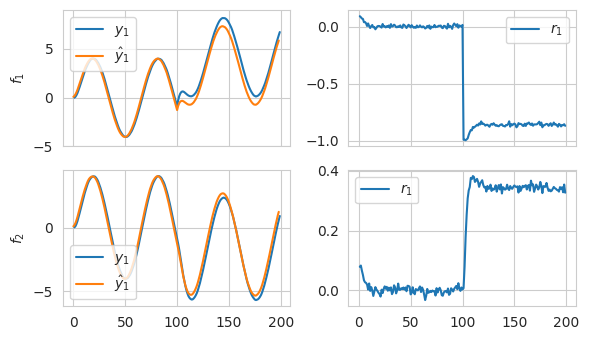

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3.5), sharex=True)

axs[0, 0].plot(df_f1[out], label='$y_1$')
axs[0, 0].plot(x1_hat_f1, label='$\hat{y}_1$')
axs[0, 0].legend()
axs[0, 0].set_ylabel('$f_1$')
axs[0, 0].set_ylim(-5, 9)
axs[0, 1].plot(x1_hat_f1 - df_f1[[out]], label='$r_1$')
axs[0, 1].legend()
axs[1, 0].plot(df_f2[out], label='$y_1$')
axs[1, 0].plot(x1_hat_f2, label='$\hat{y}_1$')
axs[1, 0].legend(loc='lower left')
axs[1, 0].set_ylabel('$f_2$')
axs[1, 1].plot(x1_hat_f2 - df_f2[[out]], label='$r_1$') 
axs[1, 1].legend()
plt.tight_layout()
plt.savefig('pic/r1_linear.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### y3 = f(u)

In [24]:
cols = ['x3(k-1)', 'u']
out = 'x3'
X = df_nf[cols]
y = df_nf[[out]]

In [25]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

In [26]:
reg.score(X, y)

0.9993948206162484

In [27]:
reg.coef_

array([[0.96346968, 0.07347245]])

In [28]:
x3_hat = reg.predict(X)

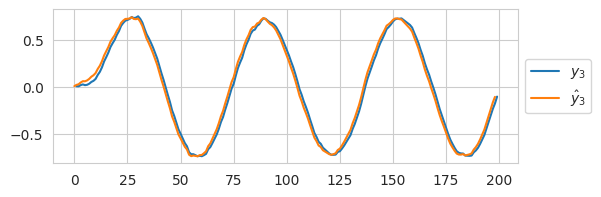

In [29]:
plt.figure(figsize=(6, 2))
plt.plot(df_nf[out], label='$y_3$');
plt.plot(x3_hat, label='$\hat{y}_3$');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

In [30]:
X = df_f1[cols]
x3_hat_f1 = reg.predict(X)
X = df_f2[cols]
x3_hat_f2 = reg.predict(X)

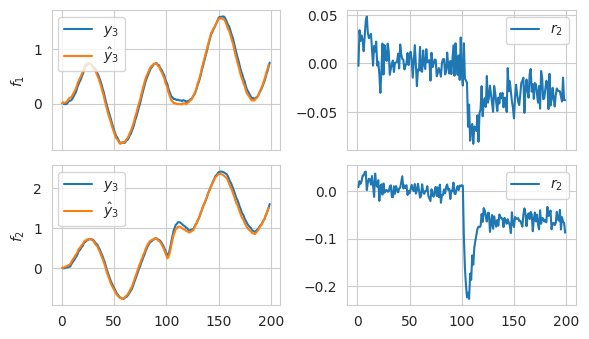

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3.5), sharex=True)

axs[0, 0].plot(df_f1[out], label='$y_3$')
axs[0, 0].plot(x3_hat_f1, label='$\hat{y}_3$')
axs[0, 0].legend(loc='upper left')
axs[0, 0].set_ylabel('$f_1$')
axs[0, 1].plot(x3_hat_f1 - df_f1[[out]], label='$r_2$')
axs[0, 1].legend()
axs[1, 0].plot(df_f2[out], label='$y_3$')
axs[1, 0].plot(x3_hat_f2, label='$\hat{y}_3$')
axs[1, 0].legend(loc='upper left')
axs[1, 0].set_ylabel('$f_2$')
axs[1, 1].plot(x3_hat_f2 - df_f2[[out]], label='$r_2$') 
axs[1, 1].legend()
plt.tight_layout()
plt.savefig('pic/r2_linear.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### y3 = f(y1)

In [32]:
cols = ['x3(k-1)', 'x1']
out = 'x3'
X = df_nf[cols]
y = df_nf[[out]]

In [33]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

In [34]:
reg.score(X, y)

0.999550901011281

In [35]:
reg.coef_

array([[0.91730113, 0.02272823]])

In [36]:
x3_hat = reg.predict(X)

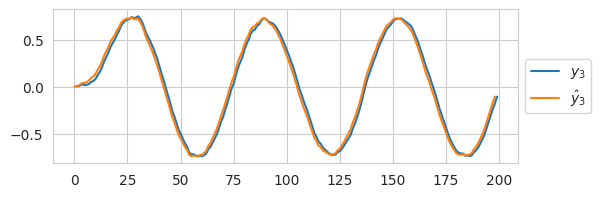

In [37]:
plt.figure(figsize=(6, 2))
plt.plot(df_nf[out], label='$y_3$');
plt.plot(x3_hat, label='$\hat{y}_3$');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

In [38]:
X = df_f1[cols]
x3_hat_f1 = reg.predict(X)
X = df_f2[cols]
x3_hat_f2 = reg.predict(X)

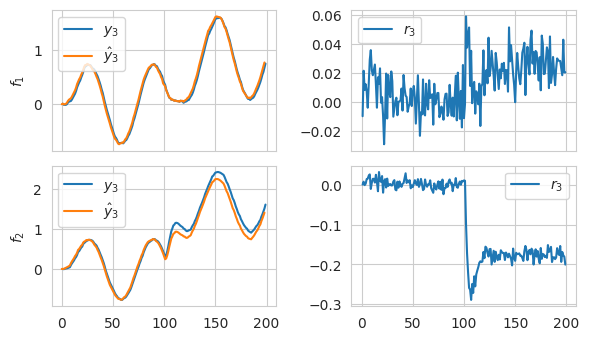

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3.5), sharex=True)

axs[0, 0].plot(df_f1[out], label='$y_3$')
axs[0, 0].plot(x3_hat_f1, label='$\hat{y}_3$')
axs[0, 0].legend(loc='upper left')
axs[0, 0].set_ylabel('$f_1$')
axs[0, 1].plot(x3_hat_f1 - df_f1[[out]], label='$r_3$')
axs[0, 1].legend()
axs[1, 0].plot(df_f2[out], label='$y_3$')
axs[1, 0].plot(x3_hat_f2, label='$\hat{y}_3$')
axs[1, 0].legend(loc='upper left')
axs[1, 0].set_ylabel('$f_2$')
axs[1, 1].plot(x3_hat_f2 - df_f2[[out]], label='$r_3$') 
axs[1, 1].legend()
plt.tight_layout()
plt.savefig('pic/r3_linear.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### y1 = f(y3, u)

In [40]:
cols = ['x1(k-1)', 'x3', 'u']
out = 'dx1'
X = df_nf[cols]
y = df_nf[[out]]

In [41]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

In [42]:
reg.score(X, y)

0.9983441106318789

In [43]:
reg.coef_

array([[-0.15952449, -0.12482877,  0.7716146 ]])

In [44]:
x1_hat = reg.predict(X)

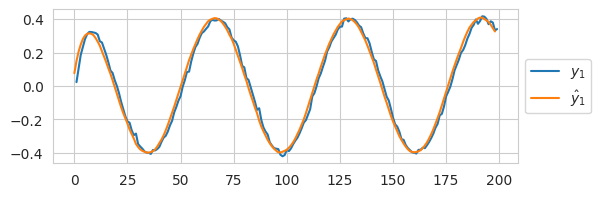

In [45]:
plt.figure(figsize=(6, 2))
plt.plot(df_nf[out], label='$y_1$');
plt.plot(x1_hat, label='$\hat{y}_1$');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

In [46]:
X = df_f1[cols]
x1_hat_f1 = reg.predict(X)
X = df_f2[cols]
x1_hat_f2 = reg.predict(X)

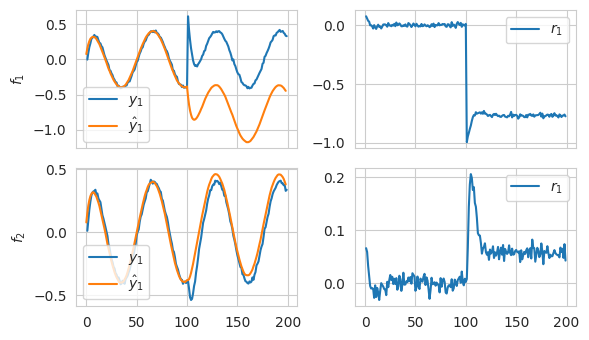

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3.5), sharex=True)

axs[0, 0].plot(df_f1[out], label='$y_1$')
axs[0, 0].plot(x1_hat_f1, label='$\hat{y}_1$')
axs[0, 0].legend()
axs[0, 0].set_ylabel('$f_1$')
axs[0, 1].plot(x1_hat_f1 - df_f1[[out]], label='$r_1$')
axs[0, 1].legend()
axs[1, 0].plot(df_f2[out], label='$y_1$')
axs[1, 0].plot(x1_hat_f2, label='$\hat{y}_1$')
axs[1, 0].legend(loc='lower left')
axs[1, 0].set_ylabel('$f_2$')
axs[1, 1].plot(x1_hat_f2 - df_f2[[out]], label='$r_1$') 
axs[1, 1].legend()
plt.tight_layout()
plt.savefig('pic/r4_linear.pdf', dpi=300, bbox_inches='tight')
plt.show()

### MSOs

In [48]:
import faultdiagnosistoolbox as fdt
import sympy as sym

#### Structural model definition

In [49]:
modeldef = {
    "type": "Symbolic",
    "x": ["x1", "x2", "x3", "dx1", "dx2", "dx3"],
    "f": ["f1", "f2"],
    "z": ["y1", "y3", "u"]
}

sym.var(modeldef["x"])
sym.var(modeldef["f"])
sym.var(modeldef["z"])

modeldef["rels"] = [
    -dx1 -0.2 * x1 - 0.1 * x2 + u + f1,
    -dx2 -0.2 * x2 + 0.1 * x1 - 0.1 * x3 + f2,
    -dx3 -0.2 * x3 + 0.1 * x2,
    -y1 + x1,
    -y3 + x3,
    fdt.DiffConstraint("dx1", "x1"),
    fdt.DiffConstraint("dx2", "x2"),
    fdt.DiffConstraint("dx3", "x3")
]

In [50]:
model = fdt.DiagnosisModel(modeldef, name="")

In [51]:
model.Lint()

Model information

  Type:Symbolic, dynamic

  Variables and equations
    6 unknown variables
    3 known variables
    2 fault variables
    8 equations, including 3 differential constraints

  Degree of redundancy: 2
  Degree of redundancy of MTES set: 1


  Model validation finished with 0 errors and 0 warnings.


In [52]:
sns.set_style("white")

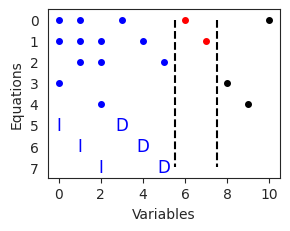

In [53]:
# structural model plot
plt.figure(figsize=(3, 3))
model.PlotModel()
plt.tight_layout()
plt.savefig('pic/structural_model.pdf', dpi=300, bbox_inches='tight')
plt.show()

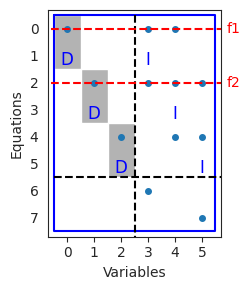

In [54]:
# Dulmage–Mendelsohn decomposition
plt.figure(figsize=(3, 3))
model.PlotDM(fault=True, eqclass=True)
plt.tight_layout()
plt.savefig('pic/dm.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# Isolability analysis
model.IsolabilityAnalysis()

array([[1, 0],
       [0, 1]])

In [56]:
# Isolability analysis in integral causality
model.IsolabilityAnalysis(causality = 'int')

array([[1, 1],
       [0, 1]])

#### MSOs

In [57]:
msos = model.MSO()
msos

[array([4, 3, 2, 7, 1, 6], dtype=int32),
 array([4, 3, 2, 7, 0, 5], dtype=int32),
 array([4, 3, 1, 6, 0, 5], dtype=int32),
 array([4, 2, 7, 1, 6, 0, 5], dtype=int32),
 array([3, 2, 7, 1, 6, 0, 5], dtype=int32)]

In [61]:
for i, e in enumerate(model.syme):
    print(i, ":   ", e)

0 :    Eq(-dx1 + f1 + u - 0.2*x1 - 0.1*x2, 0)
1 :    Eq(-dx2 + f2 + 0.1*x1 - 0.2*x2 - 0.1*x3, 0)
2 :    Eq(-dx3 + 0.1*x2 - 0.2*x3, 0)
3 :    Eq(x1 - y1, 0)
4 :    Eq(x3 - y3, 0)
5 :    ['dx1', 'x1', 'diff']
6 :    ['dx2', 'x2', 'diff']
7 :    ['dx3', 'x3', 'diff']


In [62]:
msos_low_index = [m for m in msos if model.IsLowIndex(m)]
len(msos_low_index)

4

In [63]:
# Fault signature matrix
fsm = model.FSM(msos)
fsm

array([[0, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1]])

In [64]:
# Relationship between diagnosis signals (MSOs) - known variables)
me = model.MeasurementEquations(model.z)
rsz = [[e for e in mso if e in me] for mso in msos]
for row in rsz:
    row.sort()
for row in rsz:
    print([s for e in row for s in list(model.syme[e].free_symbols) if str(s) in model.z])

[y1, y3]
[u, y1, y3]
[u, y1, y3]
[u, y3]
[u, y1]


#### M1 and M2
* For further analysis we select two MSOs wit the same known signals and different fault sensitivity
* We build two residual generatortor using M1 and M2, where $y_1$ is the model output in both cases

In [72]:
M1 = msos[1]
M2 = msos[2]

In [73]:
M1

array([4, 3, 2, 7, 0, 5], dtype=int32)

In [74]:
model.MSOCausalitySweep(M1)

['mixed', 'mixed', 'der', 'mixed', 'der', 'mixed']

In [75]:
M2

array([4, 3, 1, 6, 0, 5], dtype=int32)

In [76]:
model.MSOCausalitySweep(M2)

['der', 'int', 'der', 'mixed', 'mixed', 'int']

In [77]:
# residual generatior for M1
r = 3
M0 = [e for e in M1 if e != r]
Gamma =model.Matching(M0)
model.SeqResGen(Gamma, r, 'ResGen1')

Generating residual generator ResGen1 (Python, no batch)
  Generating code for the exactly determined part: ....
  Generating code for the residual equations
  Writing residual generator file
File ResGen1.py generated.


In [78]:
r = 3
M0 = [e for e in M2 if e != r]
Gamma =model.Matching(M0)
model.SeqResGen(Gamma, r, 'ResGen2')

Generating residual generator ResGen2 (Python, no batch)
  Generating code for the exactly determined part: ..
  Generating code for the residual equations
  Writing residual generator file
File ResGen2.py generated.


### Residuals from residual generators

In [79]:
from ResGen1 import ResGen1
from ResGen2 import ResGen2

In [80]:
def compute_residual(dat, ResGen):
    r = np.zeros(len(dat)) # N number of data points
    state = {'x1': 0, 'x2': 0, 'x3': 0}
    z = dat[['x1', 'x3', 'u']]
    x1s = []
    x3s = []
    for k, zk in enumerate(z.itertuples()):
        r[k], state = ResGen(zk[1:], state, None, 1)
        x1s.append(state['x1'])
        x3s.append(state['x3'])
    return x1s, r

#### ResGen1

In [81]:
# no fault
x1s, r = compute_residual(df_nf, ResGen1)

In [82]:
sns.set_style("whitegrid")

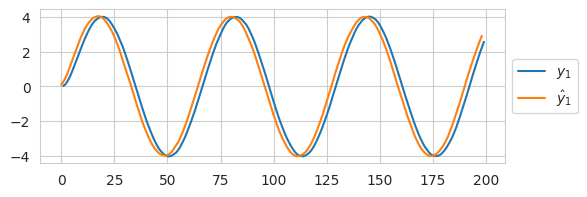

In [83]:
# x1 estimation by ResGen1
plt.figure(figsize=(6, 2))
plt.plot(df_nf['x1'], label='$y_1$');
plt.plot(x1s, label='$\hat{y}_1$');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

In [84]:
x1s_f1, r_f1 = compute_residual(df_f1, ResGen1)
x1s_f2, r_f2 = compute_residual(df_f2, ResGen1)

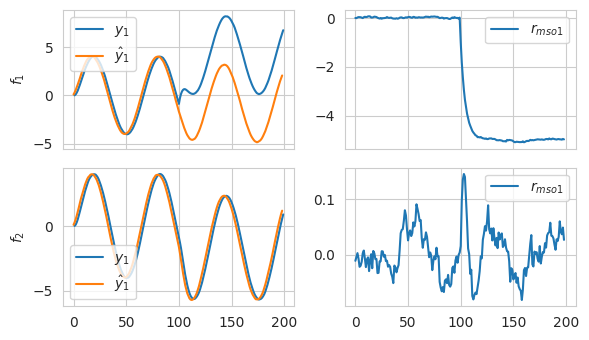

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3.5), sharex=True)

axs[0, 0].plot(df_f1['x1'], label='$y_1$')
axs[0, 0].plot(x1s_f1, label='$\hat{y}_1$')
axs[0, 0].legend()
axs[0, 0].set_ylabel('$f_1$')
axs[0, 1].plot(r_f1, label='$r_{mso1}$')
axs[0, 1].legend()
axs[1, 0].plot(df_f2['x1'], label='$y_1$')
axs[1, 0].plot(x1s_f2, label='$\hat{y}_1$')
axs[1, 0].legend(loc='lower left')
axs[1, 0].set_ylabel('$f_2$')
axs[1, 1].plot(r_f2, label='$r_{mso1}$') 
axs[1, 1].legend()
plt.tight_layout()
plt.savefig('pic/mso1.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### ResGen2

In [86]:
x1s, r = compute_residual(df_nf, ResGen2)

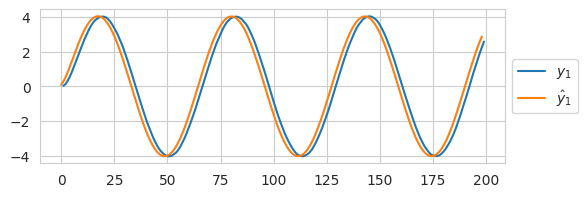

In [87]:
# x1 estimation by ResGen2
plt.figure(figsize=(6, 2))
plt.plot(df_nf['x1'], label='$y_1$');
plt.plot(x1s, label='$\hat{y}_1$');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

In [88]:
x1s_f1, r_f1 = compute_residual(df_f1, ResGen2)
x1s_f2, r_f2 = compute_residual(df_f2, ResGen2)

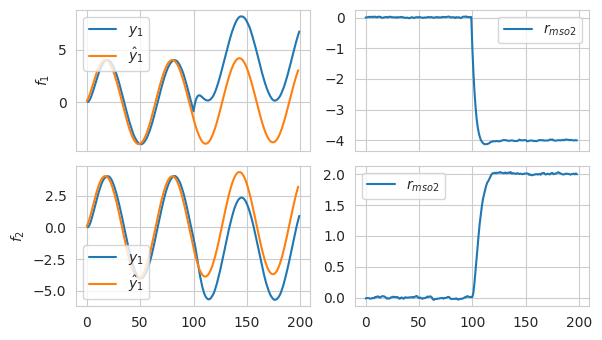

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3.5), sharex=True)

axs[0, 0].plot(df_f1['x1'], label='$y_1$')
axs[0, 0].plot(x1s_f1, label='$\hat{y}_1$')
axs[0, 0].legend()
axs[0, 0].set_ylabel('$f_1$')
axs[0, 1].plot(r_f1, label='$r_{mso2}$')
axs[0, 1].legend()
axs[1, 0].plot(df_f2['x1'], label='$y_1$')
axs[1, 0].plot(x1s_f2, label='$\hat{y}_1$')
axs[1, 0].legend(loc='lower left')
axs[1, 0].set_ylabel('$f_2$')
axs[1, 1].plot(r_f2, label='$r_{mso2}$') 
axs[1, 1].legend()
plt.tight_layout()
plt.savefig('pic/mso2.pdf', dpi=300, bbox_inches='tight')
plt.show()